In [1]:
import requests
import numpy as np
import pandas as pd
import yaml
import datetime 
import base64
import json
import pytz
import matplotlib.pyplot as plt

/Users/akprakash/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (1.25.9) or chardet (5.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Set up MIDAS conifg.yaml and credentials

In [2]:
with open("midas/config.yaml") as fp:
    config = yaml.safe_load(fp)
midas_config = config.get("midas", {})
midas_project = config.get("project", "CFCF")
midas_username = midas_config.get("username")
midas_password = midas_config.get("password")

In [3]:
def GetSchema(token):
    headers = {'accept': 'application/json', 'Authorization': "Bearer " + token}
    url = 'https://midasapi.energy.ca.gov/api/valuedata'
    pricing_response = requests.get(url, headers=headers)

    return (json.loads(pricing_response.text))

In [4]:
#Function passes through your MIDAS username and password as strings and returns the JWT token as a string
def GetToken(username, password):
    credentials = username + ":" + password
    credentials_encodedBytes = base64.b64encode(credentials.encode("utf-8"))
   
    headers = {b'Authorization': b'BASIC ' + credentials_encodedBytes}
    url = 'https://midasapi.energy.ca.gov/api/token'

    response = requests.get(url,headers=headers)
    print(response.text)

    return response.headers['Token']

In [5]:
def GetRINList(token, signaltype):
    headers = {'accept': 'application/json', 'Authorization': "Bearer " + token}
    url = 'https://midasapi.energy.ca.gov/api/valuedata?signaltype=' + signaltype
    list_response = requests.get(url, headers=headers)
    return (json.loads(list_response.text))

In [6]:
#Query passes in JWT access token as "token", Rate Identification Number (RIN) as rateID formatted as a string, and "alldata" or "realtime" for queryType formatted as a string
def GetValue(token, rateID, queryType):
    headers = {'accept': 'application/json', 'Authorization': "Bearer " + token}
    url = 'https://midasapi.energy.ca.gov/api/valuedata?id=' + rateID + '&querytype=' + queryType
    pricing_response = requests.get(url, headers=headers)

    return (json.loads(pricing_response.text))

# Get MIDAS Server Rate Function

In [7]:
url_base = 'https://api.olivineinc.com/i/lbnl/v1/prices/cfh/'
hdp_endpoint_dict = {'SummerHDP': 'USCA-CFCF-SHDP-0000',
                'SummerLD-TOU': 'USCA-CFCF-SLTU-0000',
                'SummerMildHDP': 'USCA-CFCF-SMDP-0000',
                'TwoPeakHDP': 'USCA-CFCF-TPDP-0000',
                'TwoPeakHDP-GHG': 'USCA-CFCF-TPDG-0000',
                'SummerHDP-GHG': 'USCA-CFCF-SHDG-0000',
                }

In [8]:
def get_rate(hdp_name):
    Token=GetToken(midas_username, midas_password)
    op = GetValue(Token, hdp_endpoint_dict[hdp_name], "alldata")
    st_list = []
    et_list = []
    price_list = []
    for value_dict in op['ValueInformation']:
        st = pytz.timezone("UTC").localize(datetime.datetime.strptime("{} {}".format(value_dict["DateStart"], value_dict['TimeStart']), "%Y-%m-%d %H:%M:%S")).astimezone(pytz.timezone("US/Pacific"))
        et = pytz.timezone("UTC").localize(datetime.datetime.strptime("{} {}".format(value_dict["DateEnd"], value_dict['TimeEnd']), "%Y-%m-%d %H:%M:%S")).astimezone(pytz.timezone("US/Pacific"))
        price = value_dict['value']
        st_list.append(st)
        et_list.append(et)
        price_list.append(price)

    df = pd.DataFrame(index=range(0,len(st_list)), data={'start_time': st_list, 'end_time': et_list, 'price': price_list}).set_index('start_time').sort_index()
    return df

In [9]:
def plot_rate(df, rate_name):
    plt.rcParams["figure.figsize"] = (11,5)
    fig = plt.figure()
    idx = [x.strftime('%H') for x in df.index]
    plt.step(idx, df.price, where = 'post', label = rate_name)
    plt.ylabel('$/kWh')
    plt.xlabel('Hour of Day')
    plt.grid(alpha = 0.4)
    plt.xticks(idx)
    #plt.title('TOU HDP Price Signals')
    plt.legend()
    plt.ylim(0,0.9)
    plt.show()

Token issued and will expire in 10 minutes.
SummerHDP
                                           end_time  price
start_time                                                
2023-04-05 08:00:00-07:00 2023-04-05 08:59:59-07:00  0.011
2023-04-05 09:00:00-07:00 2023-04-05 09:59:59-07:00  0.019
2023-04-05 10:00:00-07:00 2023-04-05 10:59:59-07:00  0.031
2023-04-05 11:00:00-07:00 2023-04-05 11:59:59-07:00  0.061
2023-04-05 12:00:00-07:00 2023-04-05 12:59:59-07:00  0.092
2023-04-05 13:00:00-07:00 2023-04-05 13:59:59-07:00  0.124
2023-04-05 14:00:00-07:00 2023-04-05 14:59:59-07:00  0.167
2023-04-05 15:00:00-07:00 2023-04-05 15:59:59-07:00  0.215
2023-04-05 16:00:00-07:00 2023-04-05 16:59:59-07:00  0.356
2023-04-05 17:00:00-07:00 2023-04-05 17:59:59-07:00  0.489
2023-04-05 18:00:00-07:00 2023-04-05 18:59:59-07:00  0.710
2023-04-05 19:00:00-07:00 2023-04-05 19:59:59-07:00  0.788
2023-04-05 20:00:00-07:00 2023-04-05 20:59:59-07:00  0.559
2023-04-05 21:00:00-07:00 2023-04-05 21:59:59-07:00  0.333
20

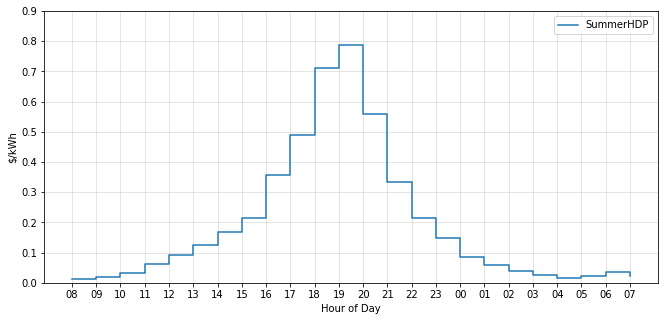

Token issued and will expire in 10 minutes.
SummerLD-TOU
                                           end_time  price
start_time                                                
2023-04-05 08:00:00-07:00 2023-04-05 08:59:59-07:00  0.031
2023-04-05 09:00:00-07:00 2023-04-05 09:59:59-07:00  0.031
2023-04-05 10:00:00-07:00 2023-04-05 10:59:59-07:00  0.031
2023-04-05 11:00:00-07:00 2023-04-05 11:59:59-07:00  0.031
2023-04-05 12:00:00-07:00 2023-04-05 12:59:59-07:00  0.031
2023-04-05 13:00:00-07:00 2023-04-05 13:59:59-07:00  0.031
2023-04-05 14:00:00-07:00 2023-04-05 14:59:59-07:00  0.264
2023-04-05 15:00:00-07:00 2023-04-05 15:59:59-07:00  0.264
2023-04-05 16:00:00-07:00 2023-04-05 16:59:59-07:00  0.698
2023-04-05 17:00:00-07:00 2023-04-05 17:59:59-07:00  0.698
2023-04-05 18:00:00-07:00 2023-04-05 18:59:59-07:00  0.698
2023-04-05 19:00:00-07:00 2023-04-05 19:59:59-07:00  0.698
2023-04-05 20:00:00-07:00 2023-04-05 20:59:59-07:00  0.698
2023-04-05 21:00:00-07:00 2023-04-05 21:59:59-07:00  0.264

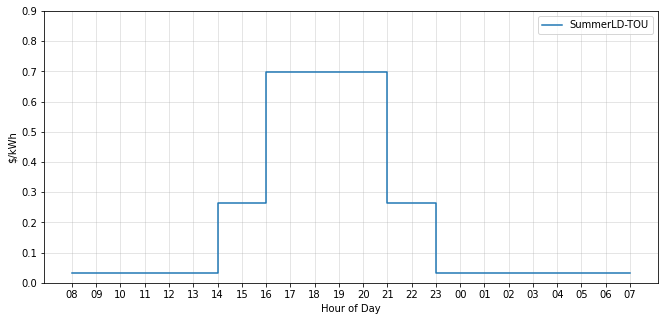

Token issued and will expire in 10 minutes.
SummerMildHDP
                                           end_time  price
start_time                                                
2023-04-05 08:00:00-07:00 2023-04-05 08:59:59-07:00  0.151
2023-04-05 09:00:00-07:00 2023-04-05 09:59:59-07:00  0.154
2023-04-05 10:00:00-07:00 2023-04-05 10:59:59-07:00  0.160
2023-04-05 11:00:00-07:00 2023-04-05 11:59:59-07:00  0.173
2023-04-05 12:00:00-07:00 2023-04-05 12:59:59-07:00  0.186
2023-04-05 13:00:00-07:00 2023-04-05 13:59:59-07:00  0.200
2023-04-05 14:00:00-07:00 2023-04-05 14:59:59-07:00  0.219
2023-04-05 15:00:00-07:00 2023-04-05 15:59:59-07:00  0.240
2023-04-05 16:00:00-07:00 2023-04-05 16:59:59-07:00  0.302
2023-04-05 17:00:00-07:00 2023-04-05 17:59:59-07:00  0.360
2023-04-05 18:00:00-07:00 2023-04-05 18:59:59-07:00  0.456
2023-04-05 19:00:00-07:00 2023-04-05 19:59:59-07:00  0.490
2023-04-05 20:00:00-07:00 2023-04-05 20:59:59-07:00  0.390
2023-04-05 21:00:00-07:00 2023-04-05 21:59:59-07:00  0.29

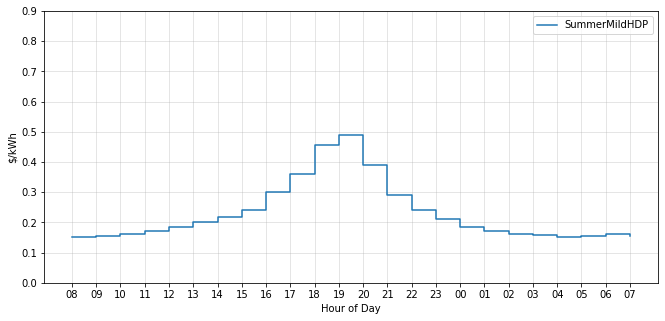

Token issued and will expire in 10 minutes.
TwoPeakHDP
                                           end_time  price
start_time                                                
2023-04-05 08:00:00-07:00 2023-04-05 08:59:59-07:00  0.280
2023-04-05 09:00:00-07:00 2023-04-05 09:59:59-07:00  0.116
2023-04-05 10:00:00-07:00 2023-04-05 10:59:59-07:00  0.040
2023-04-05 11:00:00-07:00 2023-04-05 11:59:59-07:00  0.020
2023-04-05 12:00:00-07:00 2023-04-05 12:59:59-07:00  0.011
2023-04-05 13:00:00-07:00 2023-04-05 13:59:59-07:00  0.019
2023-04-05 14:00:00-07:00 2023-04-05 14:59:59-07:00  0.026
2023-04-05 15:00:00-07:00 2023-04-05 15:59:59-07:00  0.063
2023-04-05 16:00:00-07:00 2023-04-05 16:59:59-07:00  0.096
2023-04-05 17:00:00-07:00 2023-04-05 17:59:59-07:00  0.236
2023-04-05 18:00:00-07:00 2023-04-05 18:59:59-07:00  0.493
2023-04-05 19:00:00-07:00 2023-04-05 19:59:59-07:00  0.662
2023-04-05 20:00:00-07:00 2023-04-05 20:59:59-07:00  0.536
2023-04-05 21:00:00-07:00 2023-04-05 21:59:59-07:00  0.412
2

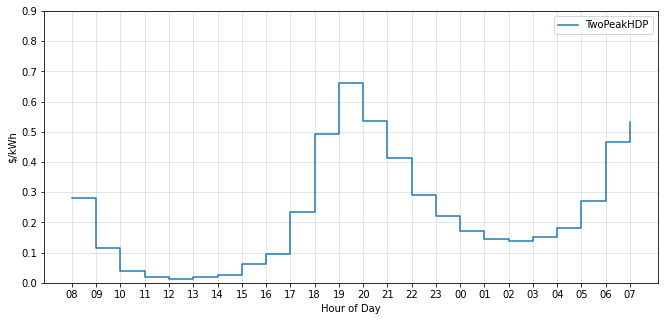

Token issued and will expire in 10 minutes.
TwoPeakHDP-GHG
                                           end_time  price
start_time                                                
2023-04-05 08:00:00-07:00 2023-04-05 08:59:59-07:00  0.203
2023-04-05 09:00:00-07:00 2023-04-05 09:59:59-07:00  0.037
2023-04-05 10:00:00-07:00 2023-04-05 10:59:59-07:00  0.022
2023-04-05 11:00:00-07:00 2023-04-05 11:59:59-07:00  0.022
2023-04-05 12:00:00-07:00 2023-04-05 12:59:59-07:00  0.022
2023-04-05 13:00:00-07:00 2023-04-05 13:59:59-07:00  0.022
2023-04-05 14:00:00-07:00 2023-04-05 14:59:59-07:00  0.021
2023-04-05 15:00:00-07:00 2023-04-05 15:59:59-07:00  0.022
2023-04-05 16:00:00-07:00 2023-04-05 16:59:59-07:00  0.215
2023-04-05 17:00:00-07:00 2023-04-05 17:59:59-07:00  0.431
2023-04-05 18:00:00-07:00 2023-04-05 18:59:59-07:00  0.424
2023-04-05 19:00:00-07:00 2023-04-05 19:59:59-07:00  0.424
2023-04-05 20:00:00-07:00 2023-04-05 20:59:59-07:00  0.421
2023-04-05 21:00:00-07:00 2023-04-05 21:59:59-07:00  0.4

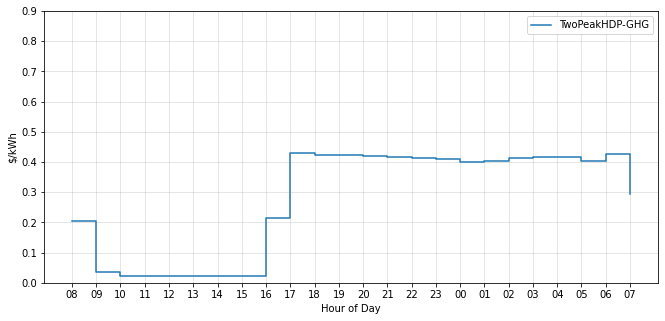

Token issued and will expire in 10 minutes.
SummerHDP-GHG
                                           end_time  price
start_time                                                
2023-04-05 08:00:00-07:00 2023-04-05 08:59:59-07:00  0.401
2023-04-05 09:00:00-07:00 2023-04-05 09:59:59-07:00  0.385
2023-04-05 10:00:00-07:00 2023-04-05 10:59:59-07:00  0.386
2023-04-05 11:00:00-07:00 2023-04-05 11:59:59-07:00  0.399
2023-04-05 12:00:00-07:00 2023-04-05 12:59:59-07:00  0.421
2023-04-05 13:00:00-07:00 2023-04-05 13:59:59-07:00  0.402
2023-04-05 14:00:00-07:00 2023-04-05 14:59:59-07:00  0.437
2023-04-05 15:00:00-07:00 2023-04-05 15:59:59-07:00  0.425
2023-04-05 16:00:00-07:00 2023-04-05 16:59:59-07:00  0.431
2023-04-05 17:00:00-07:00 2023-04-05 17:59:59-07:00  0.433
2023-04-05 18:00:00-07:00 2023-04-05 18:59:59-07:00  0.444
2023-04-05 19:00:00-07:00 2023-04-05 19:59:59-07:00  0.443
2023-04-05 20:00:00-07:00 2023-04-05 20:59:59-07:00  0.436
2023-04-05 21:00:00-07:00 2023-04-05 21:59:59-07:00  0.43

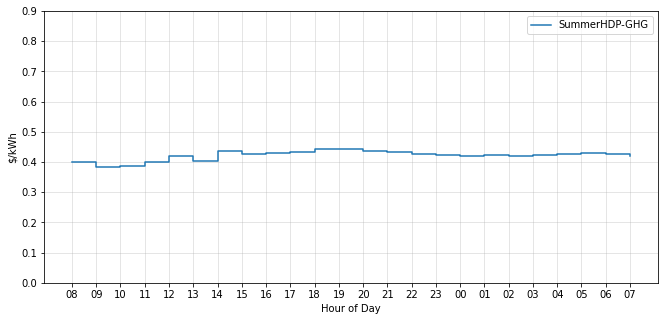

In [10]:
for rate_name, url in hdp_endpoint_dict.items():
    df = get_rate(rate_name)
    print(rate_name)
    print(df)
    plot_rate(df, rate_name)